**Install requirements**

In [ ]:
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install fvcore
!pip install ptflops

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 12.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=65fec33771fa185259f68b599111b4a1659a2092b07c68094d32f9d94a26b8c2
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=7e92a001a4d227520a791f8379fa2c8ef6c1918963ac5b9bbee7dd3c5e06650b
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 k

**Import libraries**

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import jaccard_score

import time

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# **Global variables**

In [ ]:
NUM_CLASSES = 7

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                    # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.02             # The initial Learning Rate
MOMENTUM = 0.9        # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001 # Regularization, you can keep this at the default

NUM_EPOCHS = 20      # Total number of training epochs (iterations over dataset)

# **Dataset management**

**Download Dataset LoveDA**


In [ ]:
#'''
#1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M
if not os.path.isdir('/content/LoveDA'):
  # Download the LoveDA dataset if it doesn't exist in the directory
  !gdown --id 1yzLCHM-BHGaEvt5DqnCBzaLfLF-qOQ7M # Estimated time: 3-5 minutes
  !jar xvf  "/content/LoveDA.zip" # Extract the file

# Check if the dataset was copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !gdown --id 1reDp2XdraXqPHXvmZvIXzXN8lrTphPk8

if not os.path.isfile("/content/best_model_pidnet_DS_512_32_002.pth"):
  !gdown --id 1TOziHsaq4N3iy2JOo5-uaiPrbm-UCGTr

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    # Download the model_utils.py script
    !gdown --id 1Uq3E3F6fO7qXInkS2IFGHS5WDxrrNSpr
'''

# OPTION 2
# Download LoveDA train an val dataset, from https://zenodo.org/records/5706578, extract and put them in a unique folder: LoveDA
# Download the Utils folder from github: https://github.com/Zafonte/Real-time-Domain-Adaptation-in-Semantic-Segmentation.git
# Upload in your drive the dataset and the Utils folder - then run the following line of code
from google.colab import drive
drive.mount('/content/drive')

# Copy the dataset from your Google Drive folder to /content
if not os.path.isdir('/content/LoveDA'):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/LoveDA" /content/                        #PUT your path

# Check if the dataset has been copied correctly
if not os.path.isdir('/content/LoveDA'):
    print("Dataset doesn't exist")

#Weights
if not os.path.isfile("/content/PIDNet_S_ImageNet.pth.tar"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/PIDNet_S_ImageNet.pth.tar" /content/  #PUT your path

if not os.path.isfile("/content/best_model_pidnet_DS_512_32_002.pth"):
  !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/best_model_pidnet_DS_512_32_002.pth" /content/     #PUT your path

# Utilities
if not os.path.isfile("/content/model_utils.py"):
    !cp -r "/content/drive/MyDrive/AMLProjectCode/Utils/model_utils.py" /content/           #PUT your path
'''

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/AMLProjectCode/Utils/best_model_pidnet_DS_512_32.pth': No such file or directory


**LoveDA dataset class**


In [ ]:
COLOR_MAP = OrderedDict(
    Black = (0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)


LABEL_MAP = OrderedDict(
    Black = -1,
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)


def map_labels(label):
    mapped_label = np.where(label == 0, -1, np.where(label >= 1, label - 1, label)) # Change pixel values
    return torch.tensor(mapped_label, dtype=torch.long)


class LoveDADataset(Dataset):
    def __init__(self, images_path, masks_path, image_transform=None, mask_transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted([f for f in os.listdir(images_path) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(masks_path) if f.endswith('.png')])

        # Check if the number of images matches the number of masks
        if len(self.images) != len(self.masks):
            raise ValueError("The number of images and masks does not match!")

    def __getitem__(self, idx):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target)
        '''
        # Read image and mask
        image = Image.open(os.path.join(self.images_path, self.images[idx])).convert('RGB')
        mask = Image.open(os.path.join(self.masks_path, self.masks[idx]))

        # Apply transformation to images (if present)
        if self.image_transform:
            image = self.image_transform(image)

        # Apply transformation to masks (if present)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to NumPy array for mapping
        mask_np = np.array(mask, dtype=np.int64)

        # Map labels using map_labels function
        mask_mapped = map_labels(mask_np)

        return image, mask_mapped

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        return len(self.images)

# **Network setup**

**PIDNet**: a real-time segmentation network

In [ ]:
# ------------------------------------------------------------------------------
# Written by Jiacong Xu (jiacong.xu@tamu.edu)
# ------------------------------------------------------------------------------
import sys
import os

from model_utils import BasicBlock, Bottleneck, segmenthead, DAPPM, PAPPM, PagFM, Bag, Light_Bag

import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch - extracts key features at reduced resolutions
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch - optimized for scene parsing
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch - captures fine details (edges, contours)
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        print('PIDNet-S backbone pretraining on ImageNet loading...')
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
        print('PIDNet-S backbone pretraining on ImageNet LOADED')
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

In [ ]:
# Configuration with the path to the pre-trained file
class Config:
    class MODEL:
        NAME = 's'  # Specify the model ('s', 'm', etc.)
        PRETRAINED = '/content/PIDNet_S_ImageNet.pth.tar'  # Path to file PIDNet_S pretrainato on ImageNet

    class DATASET:
        NUM_CLASSES = NUM_CLASSES  # Number of classes in the dataset


**Visualize prediction function**

In [ ]:
def visualize_prediction(image, true_mask, pred_mask):
    """
    Visualizes the original image, true mask, and predicted mask.
    Parameters:
    - image: Tensor image (C, H, W).
    - true_mask: Tensor ground truth mask.
    - pred_mask: Tensor predicted mask.
    """

    print("Comparison of true mask and prediction for a sample train image:")

    # Define ImageNet mean and standard deviation
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    image = image.cpu().numpy().transpose(1, 2, 0)  # Change image shape for matplotlib

    # If the image was normalized for the model, we need to de-normalize it
    # De-normalize the image
    image = image * std + mean  # Inverse of normalization
    image = np.clip(image, 0, 1)  # Ensure values are in the range [0, 1]

    # Convert image and masks to numpy arrays for visualization
    true_mask_np = np.array(true_mask.cpu(), dtype=np.int64)
    pred_mask_np = np.array(pred_mask.cpu(), dtype=np.int64)

    # Create a colored mask based on LABEL_MAP and COLOR_MAP
    colored_true_mask = np.zeros((true_mask_np.shape[0], true_mask_np.shape[1], 3), dtype=np.uint8)
    colored_pred_mask = np.zeros((pred_mask_np.shape[0], pred_mask_np.shape[1], 3), dtype=np.uint8)
    for class_name, color in COLOR_MAP.items():
        class_value = LABEL_MAP[class_name]  # Get the numerical value for the class
        colored_true_mask[true_mask_np == class_value] = color  # Apply correct color
        colored_pred_mask[pred_mask_np == class_value] = color  # Apply correct color

    # Create figure with subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # True mask
    ax[1].imshow(colored_true_mask)
    ax[1].set_title('True Mask')
    ax[1].axis('off')
    print(f"Unique values (mapped) in true mask: {np.unique(true_mask_np)}")

    # Predicted mask
    ax[2].imshow(colored_pred_mask)
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    print(f"Unique values in predicted mask: {np.unique(pred_mask_np)}")
    print()

    legend_patches = [mpatches.Patch(color=np.array(color) / 255.0, label=class_name) for class_name, color in COLOR_MAP.items()]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
    # Save or show the image
    plt.show()

# **Define Data Preprocessing**

In [ ]:
# Image transformation
image_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(), # Turn PIL Image to torch.Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization - Pre-trained models on ImageNet (such as ResNet101 for DeepLabV2 and PIDNet-S) expect normalized images.
])

# Mask transformation
mask_transform = transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.NEAREST)


# **Dataset object**

In [ ]:
train_dataset = LoveDADataset(
    "/content/LoveDA/Train/Urban/images_png",
    "/content/LoveDA/Train/Urban/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

print(f"Number of images in the Urban train dataset: {len(train_dataset)}")

val_dataset = LoveDADataset(
    "/content/LoveDA/Val/Rural/images_png",
    "/content/LoveDA/Val/Rural/masks_png",
    image_transform=image_transform,
    mask_transform=mask_transform
)

print(f"Number of images in the Rural validation dataset: {len(val_dataset)}")

Number of images in the Urban train dataset: 1156
Number of images in the Rural validation dataset: 992


# **Dataloaders**

In [ ]:
#DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) #batch_size: numero di immagini processate contemporaneamente
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


# **Prepare Network**

In [ ]:
# Crea l'oggetto di configurazione
cfg = Config()

# Get the model with pretrained weights from ImageNet
model = get_seg_model(cfg, imgnet_pretrained = True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

PIDNet-S backbone pretraining on ImageNet loading...


<ipython-input-6-8498e26dc231>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


PIDNet-S backbone pretraining on ImageNet LOADED


# **Validation setup**

In [ ]:
# Label mapping, excluding Black class (index -1)
LABEL = {
    'Background': 0,
    'Building': 1,
    'Road': 2,
    'Water': 3,
    'Barren': 4,
    'Forest': 5,
    'Agricultural': 6
}

# Function to compute confusion matrix
# a: ground truth, b: predictions, n: number of classes
def fast_hist(a, b, n):
    """
    Compute a confusion matrix between classes.

    Args:
        a (np.array): Ground truth (1D or 2D array).
        b (np.array): Prediction (1D or 2D array).
        n (int): Number of classes.

    Returns:
        np.array: Confusion matrix of shape n x n.
    """
    # Create a boolean index for valid values
    k = (a >= 0) & (a < n)

    # Compute confusion matrix
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

# Function to compute IoU per class
def per_class_iou(hist):
    epsilon = 1e-5  # Small constant to avoid division by zero
    # intersection = values on the diagonal of the confusion matrix
    return np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

# Function to compute mIoU on validation set
def compute_mIoU(model, val_loader, num_classes, device):
    model.eval()
    hist = np.zeros((num_classes, num_classes))

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs_resized = torch.nn.functional.interpolate(
                outputs,
                size=(512, 512),
                mode='bilinear'
            )

            preds = torch.argmax(outputs_resized, dim=1) # Predicted class

            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for lt, lp in zip(masks, preds):
                hist += fast_hist(lt.flatten(), lp.flatten(), num_classes)

    iou = per_class_iou(hist)
    mIoU = np.mean(iou)

    # Print IoU per class with class names
    print("IoU per category (%):")
    for class_idx in range(num_classes):
        class_name = list(LABEL.keys())[list(LABEL.values()).index(class_idx)]
        print(f" {class_name}: {iou[class_idx] * 100:.2f}%")
    print()

    print(f"mIoU: {mIoU * 100:.2f}%")
    print()
    return mIoU

# **Training**


In [ ]:
trained = True #SET to true if you want use the pretrained weights otherwise False
plot_training = False

Epoch 1/20:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-31-2bd70c7aa3fb>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/20: 100%|██████████| 37/37 [01:09<00:00,  1.88s/it]


Epoch 1, Learning Rate: 0.019122, Average Loss: 1.7469


IoU per category (%):
 Background: 36.96%
 Building: 18.78%
 Road: 14.55%
 Water: 30.34%
 Barren: 8.78%
 Forest: 5.06%
 Agricultural: 0.24%

mIoU: 16.39%

New best model saved with mIoU: 0.1639
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  3  5]
Unique values in predicted mask: [0 1 3 4 5]



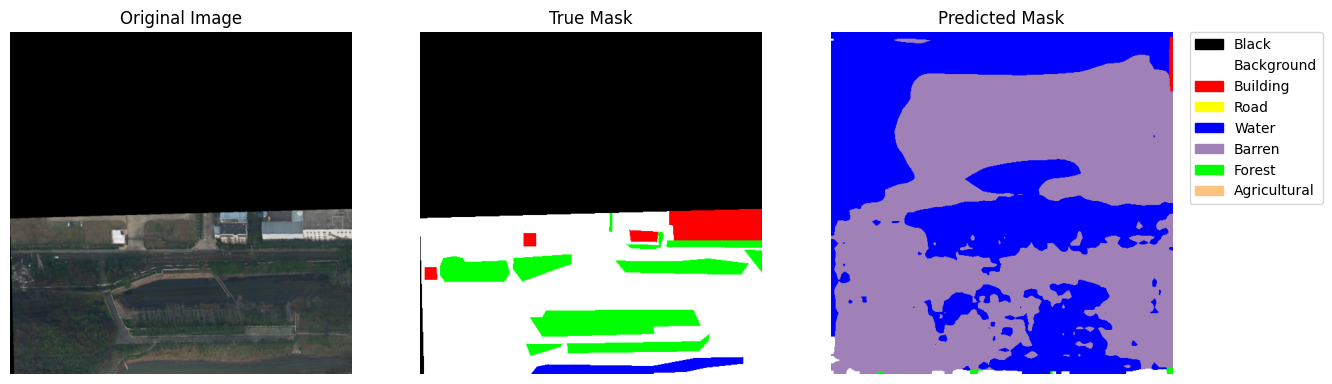

Epoch 2/20: 100%|██████████| 37/37 [01:09<00:00,  1.89s/it]


Epoch 2, Learning Rate: 0.018215, Average Loss: 0.9569


IoU per category (%):
 Background: 44.82%
 Building: 24.84%
 Road: 24.21%
 Water: 31.13%
 Barren: 7.08%
 Forest: 3.44%
 Agricultural: 0.57%

mIoU: 19.44%

New best model saved with mIoU: 0.1944
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 3 5]



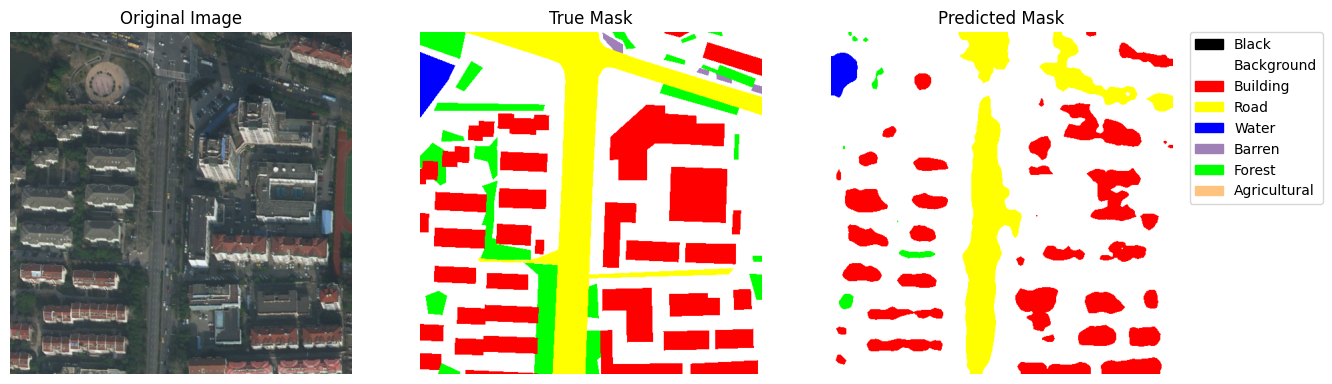

Epoch 3/20: 100%|██████████| 37/37 [01:09<00:00,  1.89s/it]


Epoch 3, Learning Rate: 0.017303, Average Loss: 0.8387


IoU per category (%):
 Background: 42.64%
 Building: 31.47%
 Road: 27.28%
 Water: 31.24%
 Barren: 8.88%
 Forest: 6.16%
 Agricultural: 11.95%

mIoU: 22.80%

New best model saved with mIoU: 0.2280
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



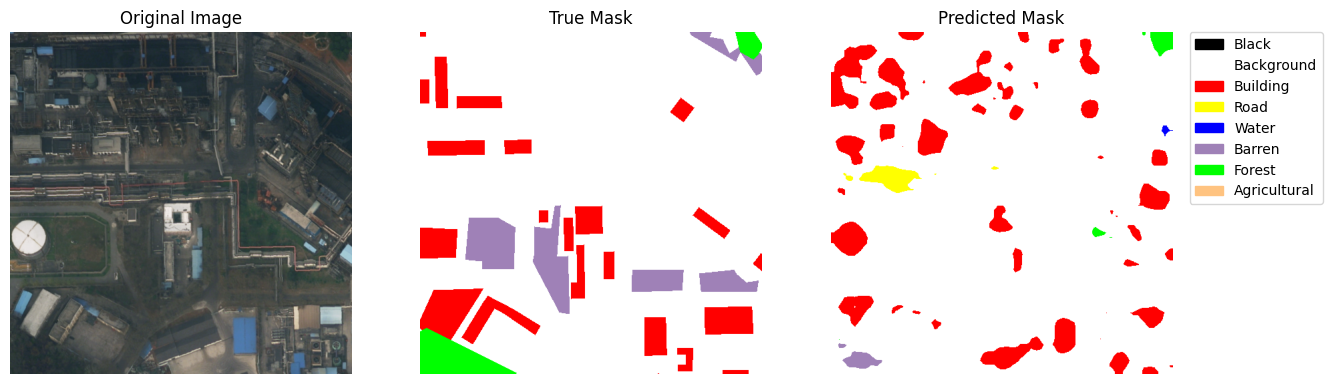

Epoch 4/20: 100%|██████████| 37/37 [01:12<00:00,  1.97s/it]


Epoch 4, Learning Rate: 0.016386, Average Loss: 0.7812


IoU per category (%):
 Background: 46.93%
 Building: 20.13%
 Road: 23.67%
 Water: 33.85%
 Barren: 5.69%
 Forest: 3.22%
 Agricultural: 18.47%

mIoU: 21.71%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  5]
Unique values in predicted mask: [0 1 2]



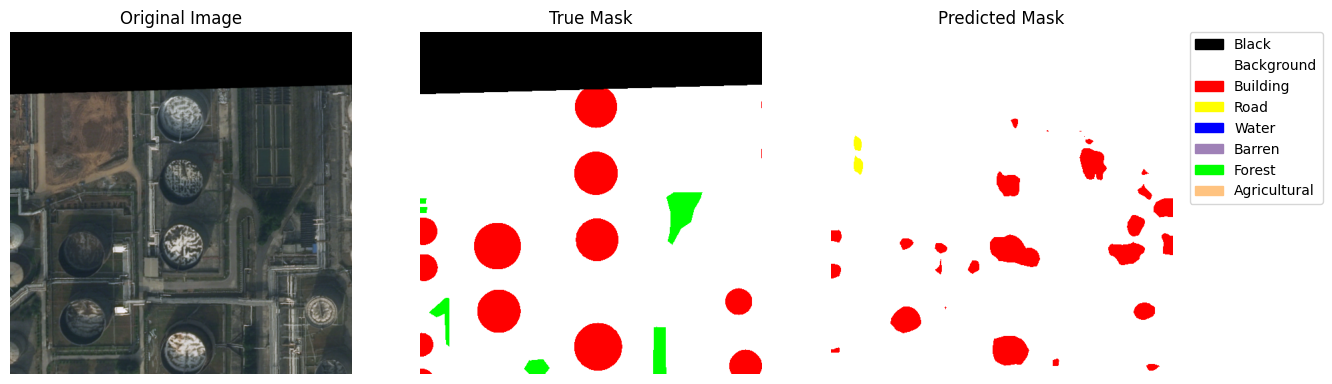

Epoch 5/20: 100%|██████████| 37/37 [01:10<00:00,  1.89s/it]



Epoch 5, Learning Rate: 0.015463, Average Loss: 0.7593
IoU per category (%):
 Background: 50.00%
 Building: 29.80%
 Road: 25.25%
 Water: 37.15%
 Barren: 11.23%
 Forest: 3.80%
 Agricultural: 29.18%

mIoU: 26.63%

New best model saved with mIoU: 0.2663
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 4 5]



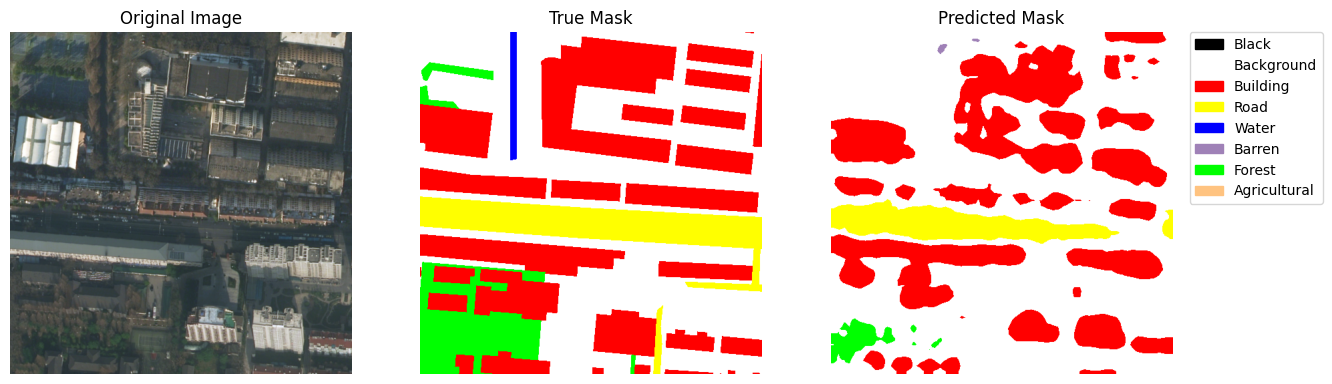

Epoch 6/20: 100%|██████████| 37/37 [01:11<00:00,  1.92s/it]


Epoch 6, Learning Rate: 0.014534, Average Loss: 0.7122


IoU per category (%):
 Background: 50.53%
 Building: 29.43%
 Road: 27.06%
 Water: 33.41%
 Barren: 8.74%
 Forest: 6.44%
 Agricultural: 32.33%

mIoU: 26.85%

New best model saved with mIoU: 0.2685
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  3]
Unique values in predicted mask: [0 1 2 3 5]



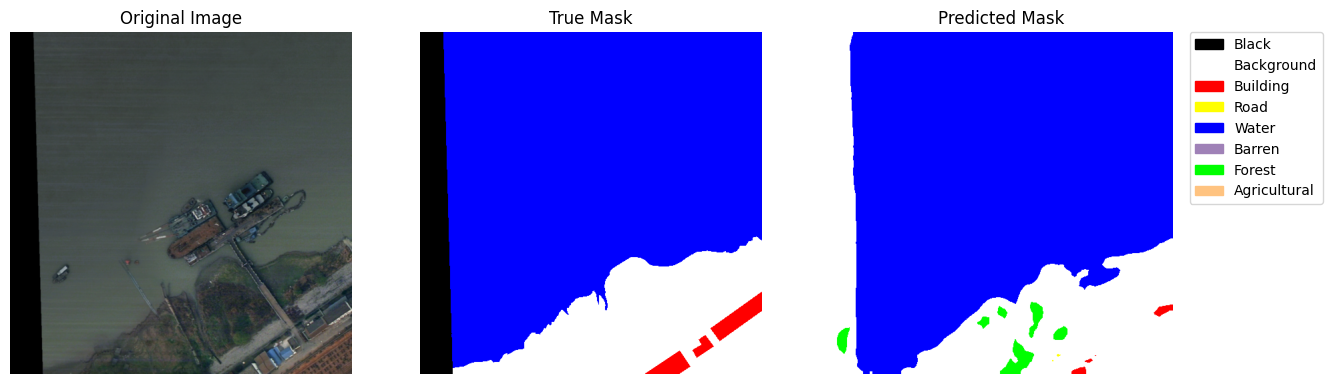

Epoch 7/20: 100%|██████████| 37/37 [01:13<00:00,  1.99s/it]


Epoch 7, Learning Rate: 0.013598, Average Loss: 0.6631


IoU per category (%):
 Background: 50.30%
 Building: 29.52%
 Road: 30.10%
 Water: 38.51%
 Barren: 9.33%
 Forest: 4.03%
 Agricultural: 31.93%

mIoU: 27.67%

New best model saved with mIoU: 0.2767
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2]
Unique values in predicted mask: [0 1 2 5]



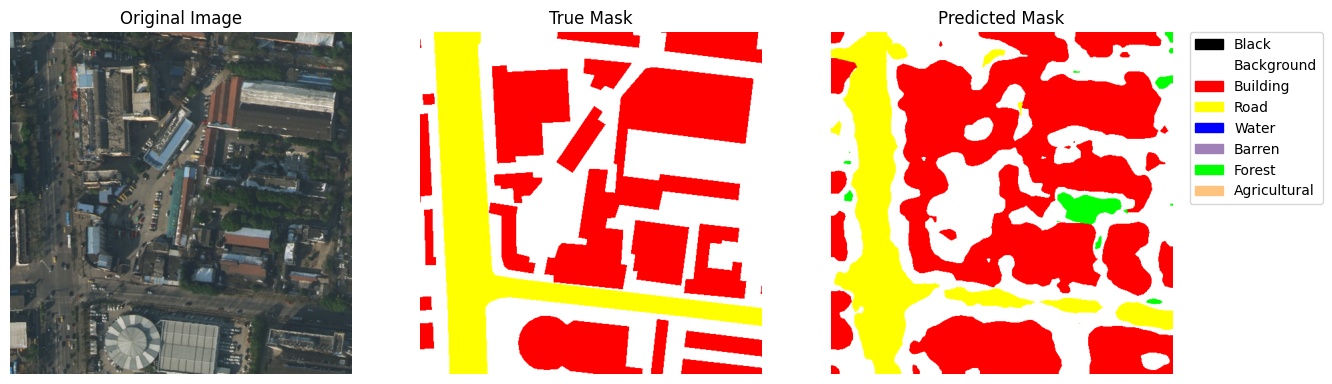

Epoch 8/20: 100%|██████████| 37/37 [01:10<00:00,  1.90s/it]



Epoch 8, Learning Rate: 0.012655, Average Loss: 0.6490
IoU per category (%):
 Background: 50.72%
 Building: 33.96%
 Road: 24.62%
 Water: 39.58%
 Barren: 9.96%
 Forest: 6.65%
 Agricultural: 29.30%

mIoU: 27.83%

New best model saved with mIoU: 0.2783
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 5]



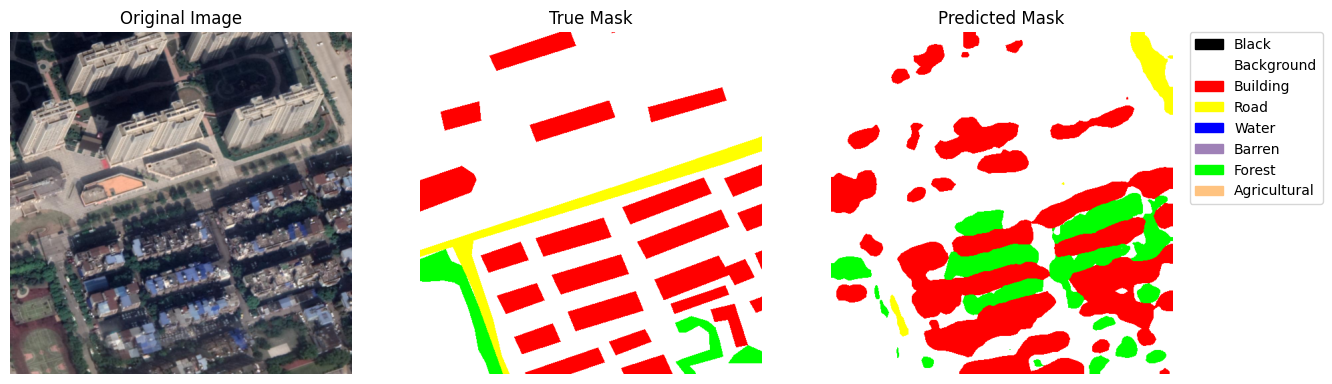

Epoch 9/20: 100%|██████████| 37/37 [01:10<00:00,  1.90s/it]


Epoch 9, Learning Rate: 0.011703, Average Loss: 0.6318


IoU per category (%):
 Background: 47.41%
 Building: 33.58%
 Road: 23.47%
 Water: 42.35%
 Barren: 9.25%
 Forest: 5.52%
 Agricultural: 23.75%

mIoU: 26.47%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  3  5  6]
Unique values in predicted mask: [0 1 2 3 4 5 6]



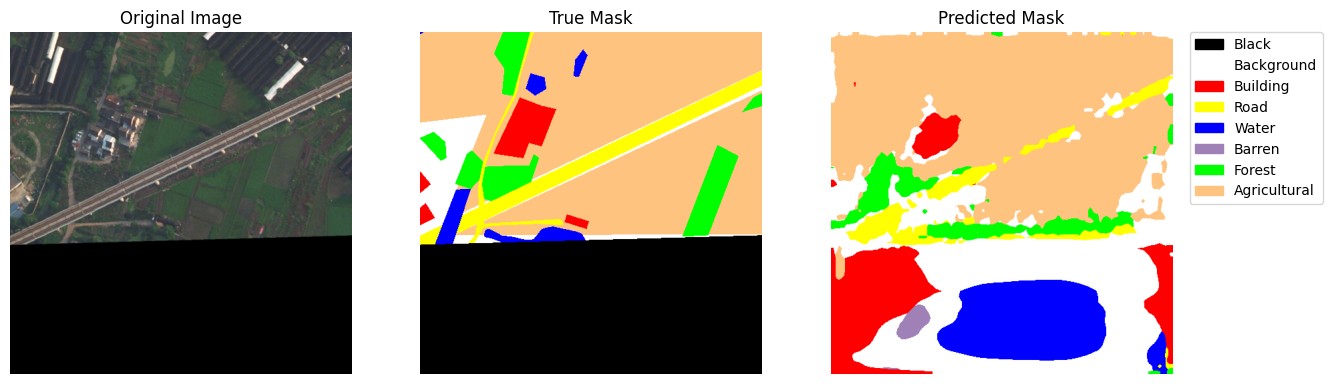

Epoch 10/20: 100%|██████████| 37/37 [01:10<00:00,  1.92s/it]


Epoch 10, Learning Rate: 0.010744, Average Loss: 0.6026


IoU per category (%):
 Background: 49.38%
 Building: 32.76%
 Road: 28.50%
 Water: 39.96%
 Barren: 9.25%
 Forest: 4.63%
 Agricultural: 30.63%

mIoU: 27.87%

New best model saved with mIoU: 0.2787
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1]
Unique values in predicted mask: [0 1 2]



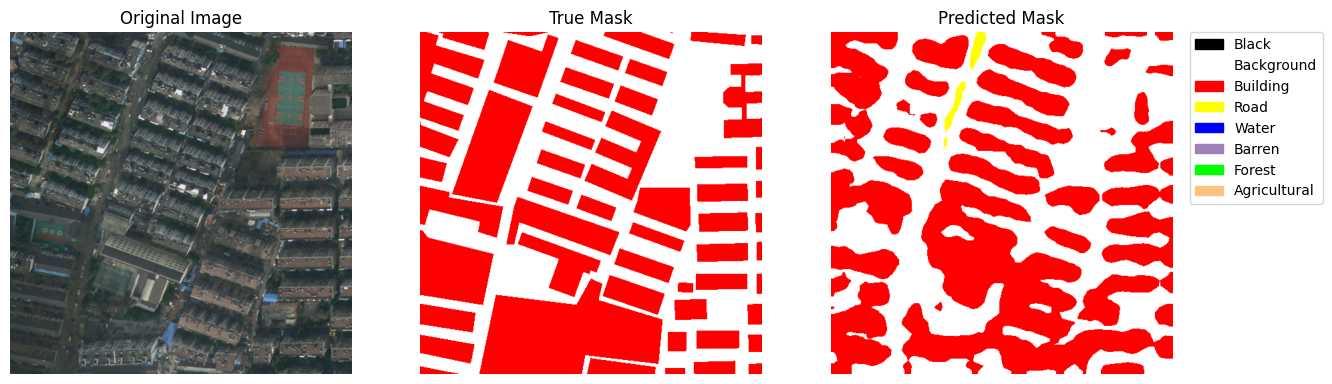

Epoch 11/20: 100%|██████████| 37/37 [01:10<00:00,  1.91s/it]


Epoch 11, Learning Rate: 0.009774, Average Loss: 0.5852


IoU per category (%):
 Background: 49.55%
 Building: 23.49%
 Road: 27.90%
 Water: 39.72%
 Barren: 8.14%
 Forest: 8.46%
 Agricultural: 31.38%

mIoU: 26.95%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 5]
Unique values in predicted mask: [0 1 2 4 5]



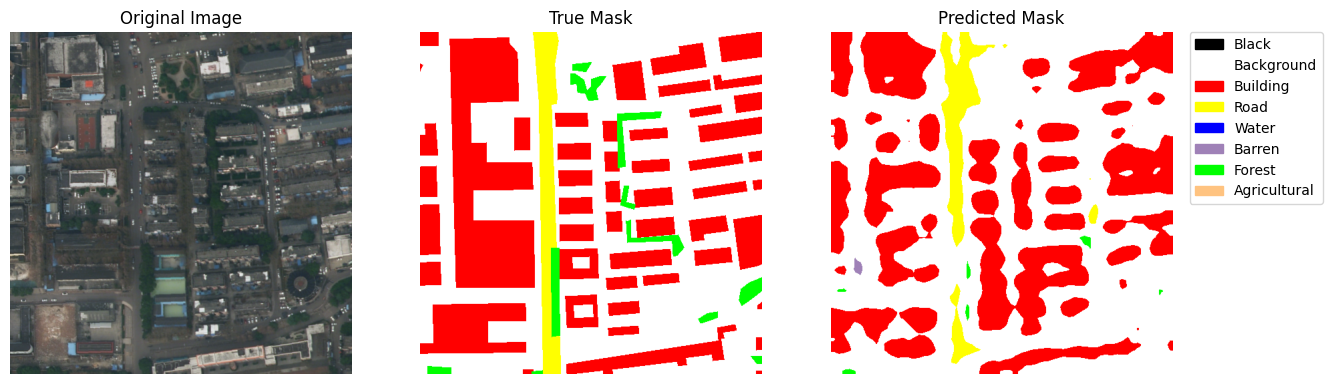

Epoch 12/20: 100%|██████████| 37/37 [01:11<00:00,  1.92s/it]


Epoch 12, Learning Rate: 0.008794, Average Loss: 0.5713


IoU per category (%):
 Background: 49.29%
 Building: 34.86%
 Road: 28.90%
 Water: 37.63%
 Barren: 7.35%
 Forest: 8.11%
 Agricultural: 34.06%

mIoU: 28.60%

New best model saved with mIoU: 0.2860
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  4  5]
Unique values in predicted mask: [0 1 2 5]



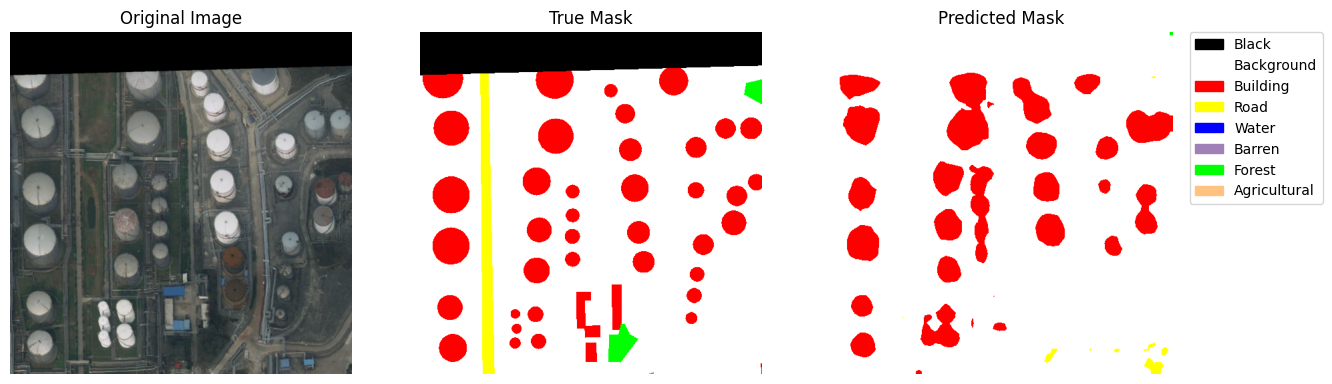

Epoch 13/20: 100%|██████████| 37/37 [01:10<00:00,  1.91s/it]


Epoch 13, Learning Rate: 0.007802, Average Loss: 0.5442


IoU per category (%):
 Background: 49.23%
 Building: 31.42%
 Road: 26.84%
 Water: 33.11%
 Barren: 10.60%
 Forest: 8.63%
 Agricultural: 30.20%

mIoU: 27.15%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4]



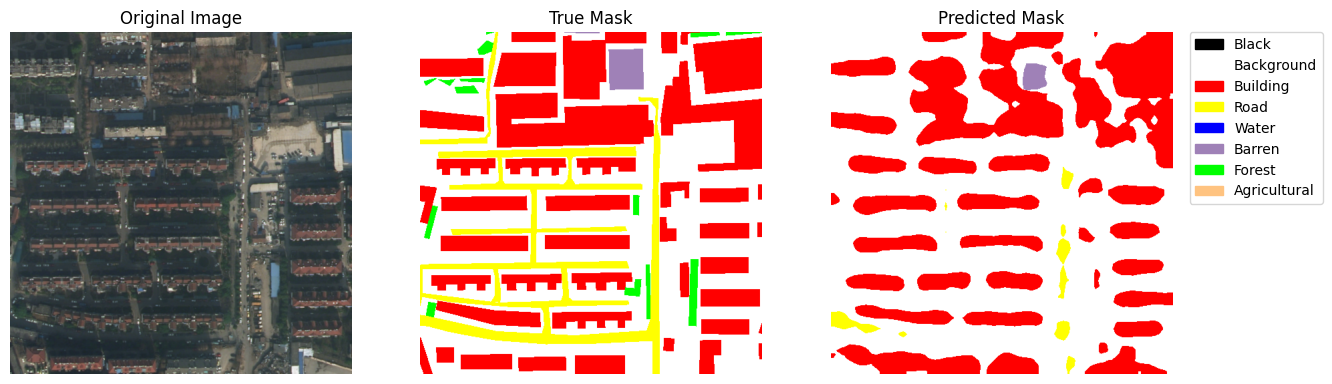

Epoch 14/20: 100%|██████████| 37/37 [01:11<00:00,  1.93s/it]


Epoch 14, Learning Rate: 0.006795, Average Loss: 0.5377


IoU per category (%):
 Background: 49.43%
 Building: 32.54%
 Road: 27.72%
 Water: 39.05%
 Barren: 9.58%
 Forest: 10.25%
 Agricultural: 32.71%

mIoU: 28.75%

New best model saved with mIoU: 0.2875
Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 3 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



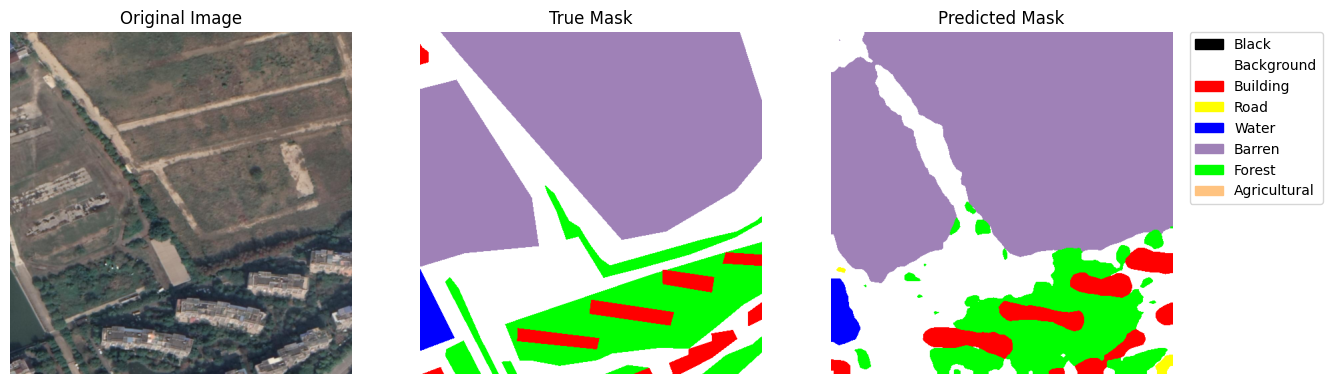

Epoch 15/20: 100%|██████████| 37/37 [01:11<00:00,  1.94s/it]


Epoch 15, Learning Rate: 0.005771, Average Loss: 0.5538


IoU per category (%):
 Background: 49.45%
 Building: 29.12%
 Road: 27.45%
 Water: 35.36%
 Barren: 5.49%
 Forest: 7.54%
 Agricultural: 29.88%

mIoU: 26.33%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 5]
Unique values in predicted mask: [0 1 2 3 5]



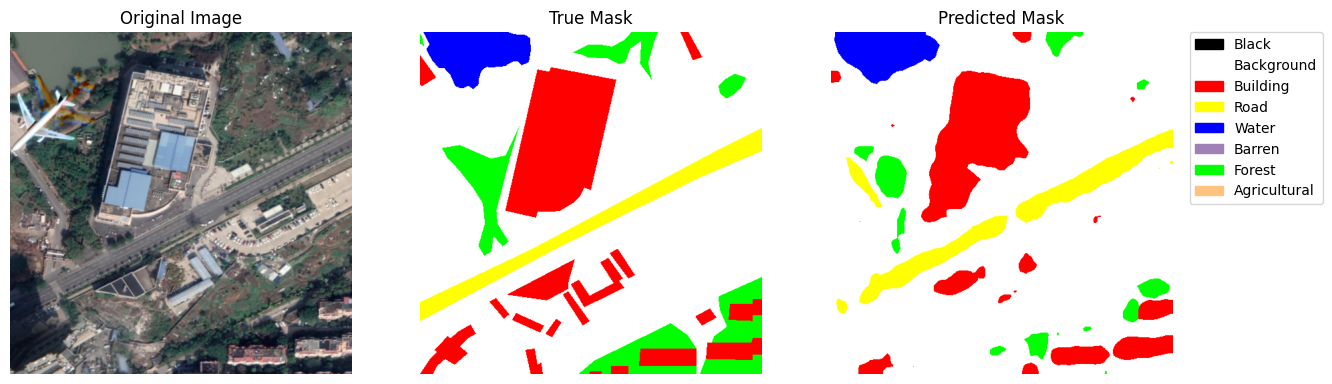

Epoch 16/20: 100%|██████████| 37/37 [01:11<00:00,  1.92s/it]


Epoch 16, Learning Rate: 0.004727, Average Loss: 0.5202


IoU per category (%):
 Background: 48.96%
 Building: 34.21%
 Road: 26.85%
 Water: 39.40%
 Barren: 6.62%
 Forest: 9.27%
 Agricultural: 30.68%

mIoU: 28.00%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 3 4 5]
Unique values in predicted mask: [0 1 2 3 4 5]



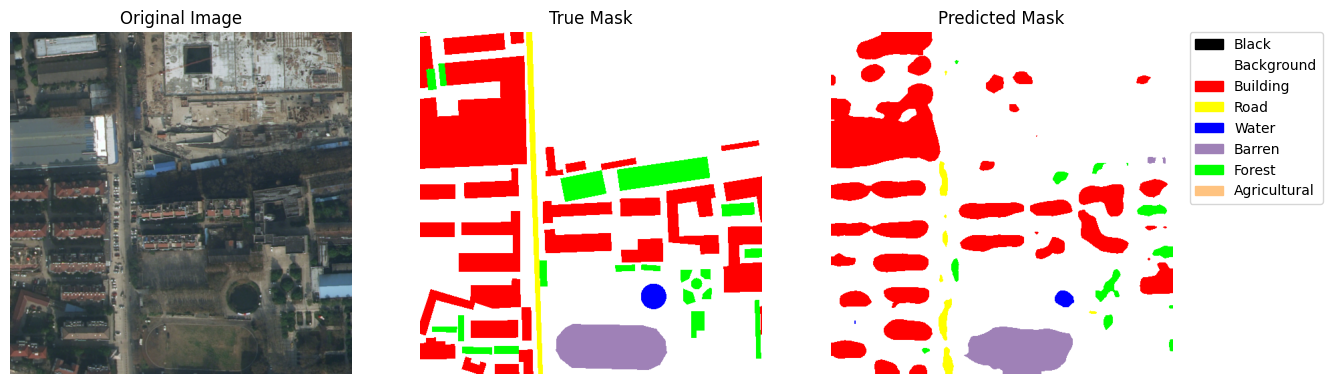

Epoch 17/20: 100%|██████████| 37/37 [01:10<00:00,  1.90s/it]


Epoch 17, Learning Rate: 0.003656, Average Loss: 0.5554


IoU per category (%):
 Background: 45.70%
 Building: 31.98%
 Road: 25.86%
 Water: 36.96%
 Barren: 6.00%
 Forest: 10.17%
 Agricultural: 29.55%

mIoU: 26.60%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



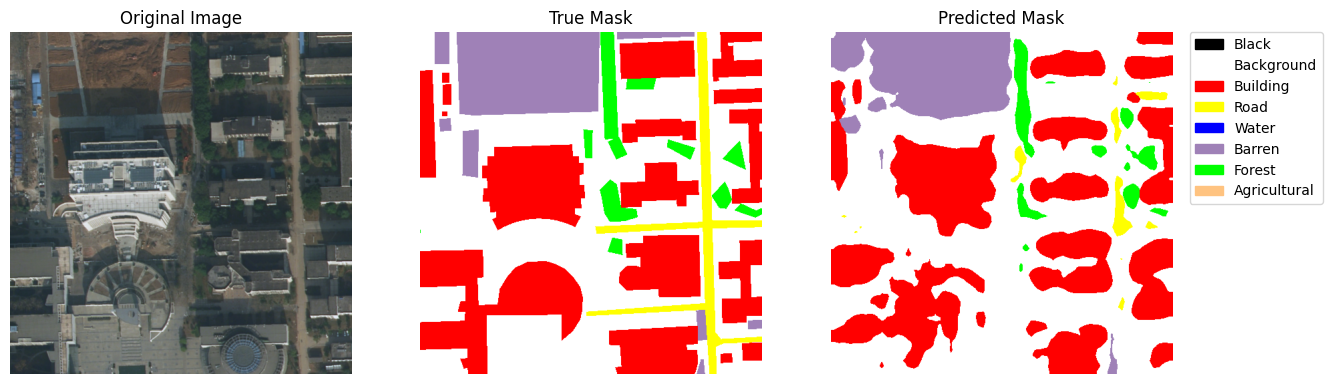

Epoch 18/20: 100%|██████████| 37/37 [01:11<00:00,  1.94s/it]


Epoch 18, Learning Rate: 0.002548, Average Loss: 0.5024


IoU per category (%):
 Background: 47.75%
 Building: 33.76%
 Road: 28.18%
 Water: 38.27%
 Barren: 7.38%
 Forest: 11.51%
 Agricultural: 30.32%

mIoU: 28.16%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2]
Unique values in predicted mask: [0 1 2 3 5]



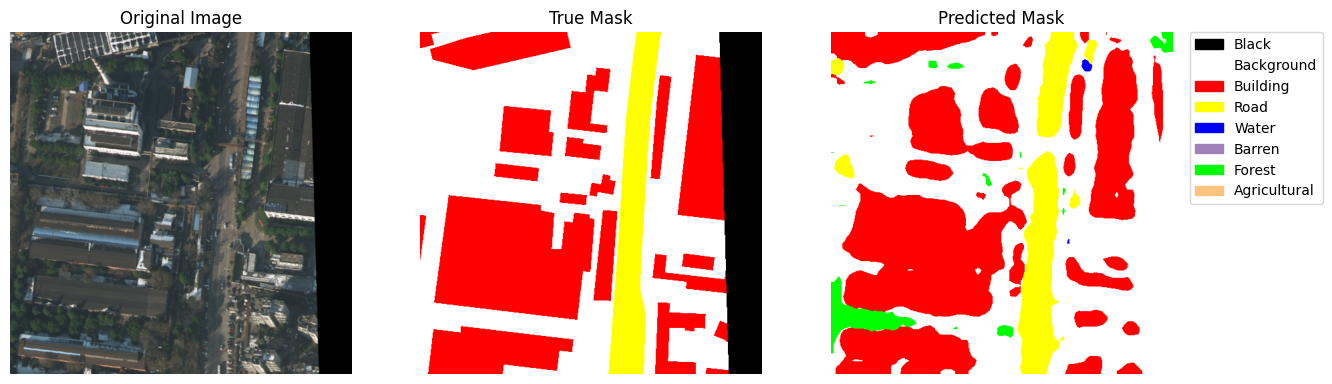

Epoch 19/20: 100%|██████████| 37/37 [01:11<00:00,  1.94s/it]


Epoch 19, Learning Rate: 0.001382, Average Loss: 0.5004


IoU per category (%):
 Background: 47.67%
 Building: 28.57%
 Road: 26.96%
 Water: 36.23%
 Barren: 7.82%
 Forest: 11.97%
 Agricultural: 30.84%

mIoU: 27.15%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [-1  0  1  2  3  4  5  6]
Unique values in predicted mask: [0 1 2 3 4 5 6]



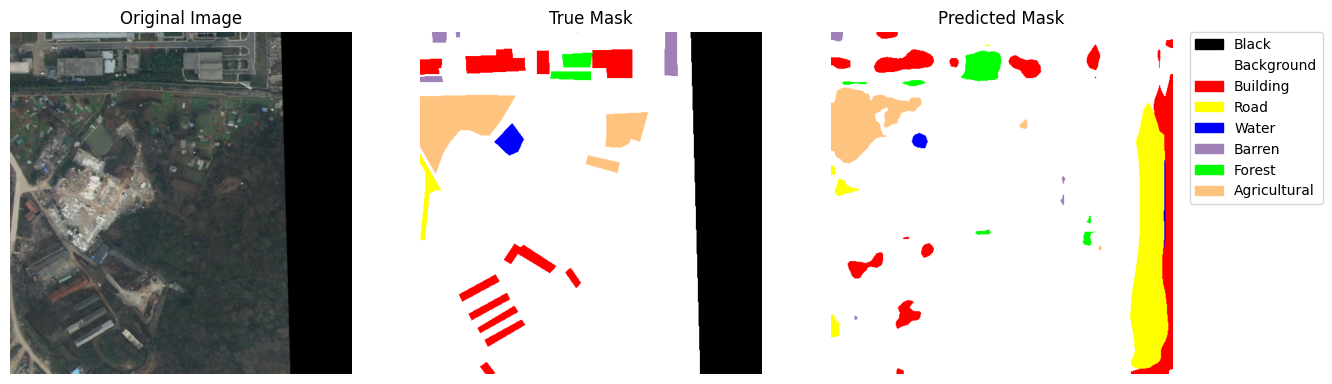

Epoch 20/20: 100%|██████████| 37/37 [01:11<00:00,  1.93s/it]


Epoch 20, Learning Rate: 0.000052, Average Loss: 0.5123


IoU per category (%):
 Background: 50.05%
 Building: 27.92%
 Road: 25.70%
 Water: 38.96%
 Barren: 8.73%
 Forest: 10.57%
 Agricultural: 28.10%

mIoU: 27.15%

Comparison of true mask and prediction for a sample train image:
Unique values (mapped) in true mask: [0 1 2 4 5]
Unique values in predicted mask: [0 1 2 4 5]



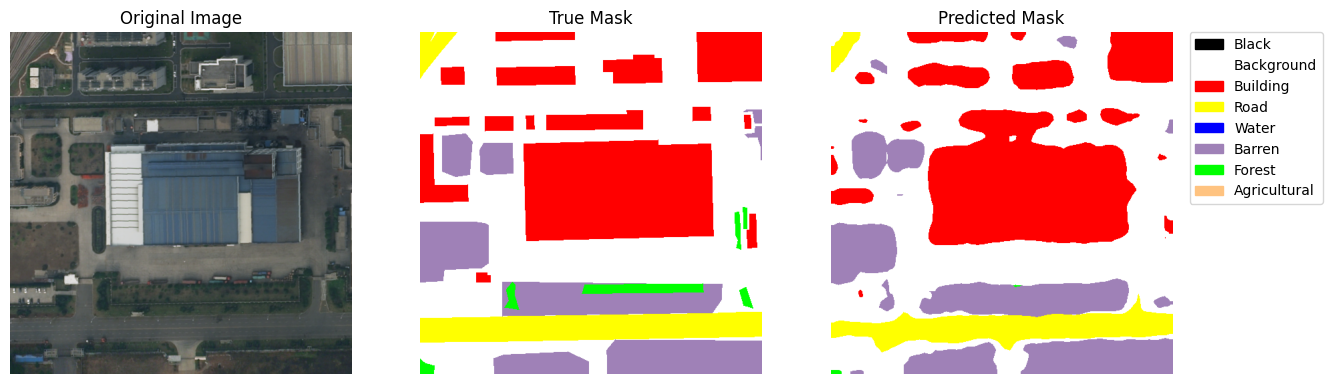

In [ ]:
#Scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, max_iter, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Optimizer configuration, loss function, and GradScaler
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(ignore_index = -1)

# Training loop
scaler = torch.amp.GradScaler()
num_epochs = NUM_EPOCHS
global_iter = 0  # Global iteration counter

loss_history = []
lr_history = []
miou_history = []

best_miou = 0.0  # Initialize best mIoU

if trained == False:
  for epoch in range(num_epochs):
      model.train()
      total_loss = 0.0

      for images, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
          images, masks = images.to(device), masks.to(device)

          optimizer.zero_grad()
          with torch.cuda.amp.autocast():
              outputs = model(images)
              #Scale the output to the desired size x = torch.nn.functional.interpolate(x, size=(H, W), mode='bilinear')
              outputs_resized = torch.nn.functional.interpolate(outputs, size=(512, 512), mode='bilinear')
              loss = criterion(outputs_resized, masks) # Compute loss

          scaler.scale(loss).backward() # Backpropagation
          scaler.step(optimizer)             # Update weights
          scaler.update()                     # Update GradScaler

          lr = poly_lr_scheduler(optimizer, init_lr=LR, iter=global_iter, max_iter=len(train_loader) * num_epochs)
          global_iter += 1

          total_loss += loss.item()

      avg_loss = total_loss / len(train_loader)
      loss_history.append(avg_loss)  # Append to the list
      lr_history.append(lr)          # Append learning rate to the list
      print()
      print(f"Epoch {epoch + 1}, Learning Rate: {lr:.6f}, Average Loss: {avg_loss:.4f}")

      # Validation every epoch
      mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)
      miou_history.append(mIoU)
      # Save the best model based on mIoU
      if mIoU > best_miou:
            best_miou = mIoU
            torch.save(model.state_dict(), "best_model_pidnet_DS_512_32_002.pth")
            print(f"New best model saved with mIoU: {best_miou:.4f}")

      model.eval()
      '''Take a sample image and compare prediction'''
        # Load a batch of data
      sample_image, sample_label = next(iter(train_loader))  # A batch from DataLoader
      sample_image = sample_image[0]  # Select a single example
      sample_label = sample_label[0]

      # Get prediction from model
      with torch.no_grad():
          sample_image = sample_image.to(device)  # Transfer image to correct device
          pred_mask = model(sample_image.unsqueeze(0)) # Add batch dimension
          pred_mask_resized = torch.nn.functional.interpolate(
              pred_mask,
              size=(512, 512),
              mode='bilinear'
          )
          pred_mask = pred_mask_resized.argmax(dim=1).squeeze(0)  # Predicted class

      # Visualize prediction
      visualize_prediction(sample_image, sample_label, pred_mask)

      trained = True
      plot_training = True
else:
  print("Model already trained")
  model.load_state_dict(torch.load("/content/best_model_pidnet_DS_512_32_002.pth", weights_only=True))
  model.to(device)

# **Results**

In [ ]:
model.load_state_dict(torch.load("/content/best_model_pidnet_DS_512_32_002.pth", weights_only=True))
model.to(device)
# Compute mIoU
mIoU = compute_mIoU(model, val_loader, num_classes=NUM_CLASSES, device=device)

IoU per category (%):
 Background: 49.43%
 Building: 32.54%
 Road: 27.72%
 Water: 39.05%
 Barren: 9.58%
 Forest: 10.25%
 Agricultural: 32.71%

mIoU: 28.75%



## Final graph


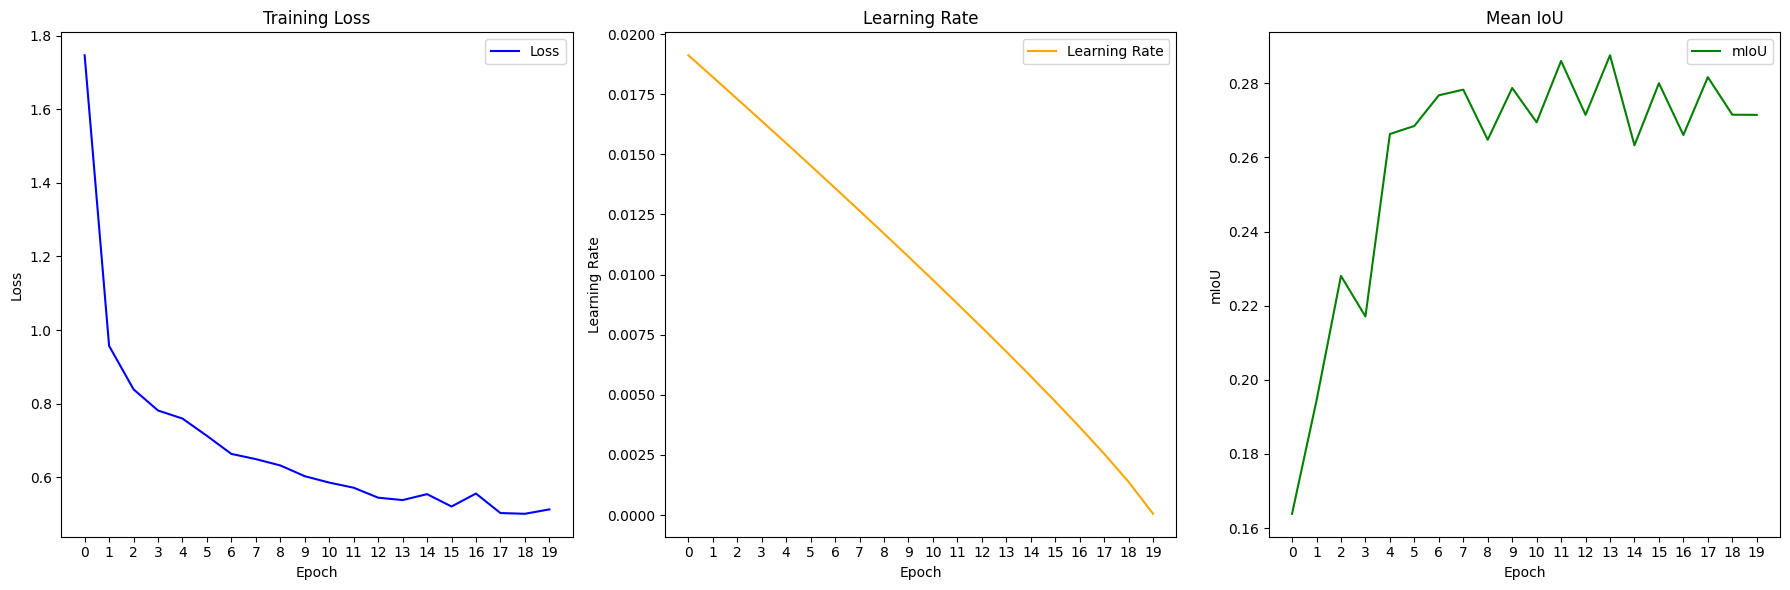

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(loss_history, lr_history, miou_history):
    """
    Funzione per tracciare il grafico di loss, learning rate e mIoU.

    Parametri:
    - loss_history: lista contenente i valori di loss per ogni epoca.
    - lr_history: lista contenente i valori di learning rate per ogni epoca.
    - miou_history: lista contenente i valori di mIoU calcolati ogni 5 epoche.
    """
    plt.figure(figsize=(18, 6))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(loss_history, label='Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.xticks(range(len(loss_history))) # Set xticks to integers

    # Learning Rate plot
    plt.subplot(1, 3, 2)
    plt.plot(lr_history, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.xticks(range(len(lr_history)))  # Set xticks to integers

    # mIoU plot
    plt.subplot(1, 3, 3)
    plt.plot(miou_history, label='mIoU', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title('Mean IoU')
    plt.legend()
    plt.xticks(range(len(miou_history)))

    plt.tight_layout()
    plt.show()

if plot_training:
  # function to plot the graph
  plot_training_metrics(loss_history, lr_history, miou_history)
